In [1]:
# !pip install -Uqq fastbook

In [2]:
# !pip install graphviz

In [3]:
import fastbook
fastbook.setup_book()

In [4]:
from fastai.vision.all import *
from fastbook import *

In [5]:
dir(URLs)

['ADULT_SAMPLE',
 'AG_NEWS',
 'AMAZON_REVIEWS',
 'AMAZON_REVIEWS_POLARITY',
 'BIWI_HEAD_POSE',
 'BIWI_SAMPLE',
 'CALTECH_101',
 'CAMVID',
 'CAMVID_TINY',
 'CARS',
 'CIFAR',
 'CIFAR_100',
 'COCO_SAMPLE',
 'COCO_TINY',
 'CUB_200_2011',
 'DBPEDIA',
 'DOGS',
 'FLOWERS',
 'FOOD',
 'HUMAN_NUMBERS',
 'IMAGENETTE',
 'IMAGENETTE_160',
 'IMAGENETTE_320',
 'IMAGEWANG',
 'IMAGEWANG_160',
 'IMAGEWANG_320',
 'IMAGEWOOF',
 'IMAGEWOOF_160',
 'IMAGEWOOF_320',
 'IMDB',
 'IMDB_SAMPLE',
 'LOCAL_PATH',
 'LSUN_BEDROOMS',
 'MACAQUES',
 'MDL',
 'ML_100k',
 'ML_SAMPLE',
 'MNIST',
 'MNIST_SAMPLE',
 'MNIST_TINY',
 'MNIST_VAR_SIZE_TINY',
 'MT_ENG_FRA',
 'OPENAI_TRANSFORMER',
 'PASCAL_2007',
 'PASCAL_2012',
 'PETS',
 'PLANET_SAMPLE',
 'PLANET_TINY',
 'S3',
 'S3_AUDI',
 'S3_COCO',
 'S3_IMAGE',
 'S3_IMAGELOC',
 'S3_MODEL',
 'S3_NLP',
 'SIIM_SMALL',
 'SOGOU_NEWS',
 'TCGA_SMALL',
 'URL',
 'WIKITEXT',
 'WIKITEXT_TINY',
 'WT103_BWD',
 'WT103_FWD',
 'YAHOO_ANSWERS',
 'YELP_REVIEWS',
 'YELP_REVIEWS_POLARITY',
 'ZEBRA_FINC

In [6]:
path = untar_data(URLs.MNIST_SAMPLE)

In [7]:
path

Path('/Users/flo/.fastai/data/mnist_sample')

In [8]:
path.ls()

(#3) [Path('/Users/flo/.fastai/data/mnist_sample/valid'),Path('/Users/flo/.fastai/data/mnist_sample/labels.csv'),Path('/Users/flo/.fastai/data/mnist_sample/train')]

In [9]:
threes = (path / 'train/3').ls().sorted()
sevens = (path / 'train/7').ls().sorted()

In [10]:
img = Image.open(threes[0])
img

In [11]:
import pandas as pd

In [50]:
df = pd.DataFrame(array(img))
df.style.set_properties(font_size='3pt').background_gradient('Greys')
# df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,42,118,219,166,118,118,6,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,103,242,254,254,254,254,254,66,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,18,232,254,254,254,254,254,238,70,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,104,244,254,224,254,254,254,141,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,207,254,210,254,254,254,34,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,84,206,254,254,254,254,41,0,0,0,0,0,0,0,0,0


In [13]:
seven_tensors = [tensor(Image.open(p)) for p in sevens]
three_tensors = [tensor(Image.open(p)) for p in threes]

In [14]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens.shape, stacked_threes.shape

(torch.Size([6265, 28, 28]), torch.Size([6131, 28, 28]))

<AxesSubplot:>

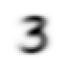

In [15]:
matplotlib.rc('image', cmap='Greys')

show_image(stacked_threes.mean(0))

## Functions and gradients

/Users/flo/miniconda3/envs/learn-ml/lib/python3.7/site-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(min,max)


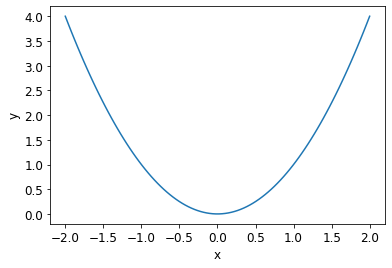

In [16]:
def f(x): return x**2
plot_function(f, 'x', 'y')

In [17]:
# Create a tensor to hold a value and tell it that
# we want gradients tracked while that value is used in functions
xt = tensor(3.).requires_grad_()

In [18]:
# The result of the function returns a new tensor
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [19]:
# The input tensor is still unmodified
xt

tensor(3., requires_grad=True)

In [20]:
# No gradients are computed yet
xt.grad

In [21]:
# xt.backward()

In [22]:
# xt.grad

In [23]:
# Compute the gradient on the resulting tensor, which propagates it back to all input tensors (?)
yt.backward()

In [24]:
# Now the gradient on the input tensor is correct
xt.grad

tensor(6.)

In [25]:
# reset it before calling backward() again, otherwise the gradients are accumulated
xt.grad = None
xt.grad

## MNIST training

### Train dataset

In [26]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape

torch.Size([12396, 784])

In [81]:
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [82]:
train_y[0]

tensor([1])

In [62]:
data_train = list(zip(train_x, train_y))

### Validation dataset

In [63]:
sevens_valid_tensors = [tensor(Image.open(p)) for p in (path / 'valid/7').ls().sorted()]
threes_valid_tensors = [tensor(Image.open(p)) for p in (path / 'valid/3').ls().sorted()]

In [64]:
threes_valid_stacked = torch.stack(threes_valid_tensors).float()/255
sevens_valid_stacked = torch.stack(sevens_valid_tensors).float()/255

In [65]:
valid_x = torch.cat([threes_valid_stacked, sevens_valid_stacked]).view(-1, 28*28)
valid_x.shape

torch.Size([2038, 784])

In [66]:
valid_y = tensor(
    [1] * len(threes) + [0] * len(sevens)
).unsqueeze(1)
valid_y.shape

torch.Size([12396, 1])

In [67]:
data_valid = list(zip(valid_x, valid_y))

### Model parameters

In [68]:
def init_params(size, std=1.):
    return (torch.randn(size) * std).requires_grad_()

In [69]:
weights = init_params((28*28, 1))
weights.shape

torch.Size([784, 1])

In [70]:
bias = init_params(1)
bias.shape

torch.Size([1])

### Predictions

In [71]:
# Correct: weights must be transposed!
(train_x[0] * weights.T).sum() + bias

tensor([14.0882], grad_fn=<AddBackward0>)

In [72]:
# Careful: forgetting to transpose does not raise an error!
(train_x[0] * weights).sum() + bias

tensor([-1122.7035], grad_fn=<AddBackward0>)

In [73]:
def linear1(xb):
    return xb@weights + bias

In [74]:
preds = linear1(train_x)

In [75]:
preds.shape

torch.Size([12396, 1])

In [76]:
preds

tensor([[14.0882],
        [13.9915],
        [16.0442],
        ...,
        [ 1.2085],
        [ 1.7146],
        [ 2.6879]], grad_fn=<AddBackward0>)

In [77]:
corrects = ((preds > 0.0).float() == train_y).float().mean().item()

# weird: in the book example, this is at close to 50%
corrects

0.4960688054561615

### MNIST Loss

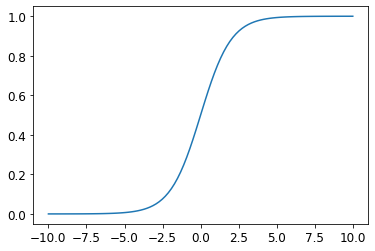

In [78]:
def sigmoid(x):
    return 1 / (1+torch.exp(-x))
plot_function(sigmoid, min=-10, max=+10)

In [79]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()  # pytorch builtin
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [80]:
mnist_loss(preds, train_y)

tensor(0.5038, grad_fn=<MeanBackward0>)

In [83]:
plot_function

<function fastbook.plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6, 4))>